# Part 1: Downloading Images from Aquarium
This code requires a username and password to access Aquarium's data and cannot be run without it. If you would like access to the login credentials, please contact Maddy Scott at mtscott321@gmail.com with the subject line REQUEST: Aquarium Credentials. 

**Importing necessary modules**

Includes **pydent**, the Aquarium module for python. **pydent** can be installed throuhg pip: https://pypi.org/project/pydent/

In [108]:
from pydent import AqSession #pydent is the Aquarium module for python, installable using pip
import os
import datetime
from PIL import Image, ExifTags
import cv2
import numpy as np
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics

**Defining basic global variables**

In [2]:
username = "maddyscott"
password = "duckweedrox"
plan_id = 42046
cwd = os.getcwd()
dir_path_original= "%s/Images_Plan_%d" % (cwd, plan_id)
dir_path_resized= "%s/Images_%d_CROPPED" % (cwd, plan_id)
dir_path_green= "%s/Images_%d_JUSTGREEN" % (cwd, plan_id)
REDUCTION = 10
PETRI_DIAM = 95 #in mm, the diameter of the TOP lid of the petri dish

**Functions for renaming image files and checking to make sure the image is rotated correctly**

In [27]:
#takes in the image metadata and reformats it
def parse_datetime(x):
    x = x.replace(" ", ":")
    splt = x.split(":")
    datime = "yr_%s_month_%s_day_%s_hour_%s" % (splt[0], splt[1], splt[2], splt[3])
    return datime

#takes a file name of the format defined in "parse_datetime()" and returns the month, day, and hour
def file_to_datetime(filename):
    f = filename.split("_")
    year = int(f[3])
    month = int(f[5])
    day = int(f[7])
    hr = int(f[9].split(".")[0])
    return year, month, day, hr  

#returns the difference between two dates
def days_since_start(oldest, file):
    m, d, hr = file_to_datetime(file)
    new = datetime(2021, m, d, hr, 0, 0)
    return (new-oldest).total_seconds()/(60*60*24)

#takes an image and renames it. If the image has been rotated, it returns it to the original orientation
def rename(upload_name, item_id):
    #now, we're going to open the image to get the metadata and rename it
    im = Image.open(os.path.join(dir_path_original, upload_name))
    datetime = parse_datetime(im._getexif()[36867])
    new_name = "item_%s_%s.jpg" % (str(item_id), datetime)
    
    #rotate the image to ensure the orientation is correct
    #search for keys until you land on the numerical value for orientation
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation]=='Orientation':
            break
    #getting the metadata and ensuring we preserve image rotation
    exif=dict(im._getexif().items())
    if exif[orientation] == 3 : 
        im=im.rotate(180, expand=True)
    elif exif[orientation] == 6 : 
        im=im.rotate(270, expand=True)
    elif exif[orientation] == 8 : 
        im=im.rotate(90, expand=True)
    
    im.save(os.path.join(dir_path_original, new_name))
    os.remove(os.path.join(dir_path_original, upload_name))
    
#takes in an image and a circle and crops the image to that circle (in our case, the circle is the petri dish)
def crop_to_dish(img, i):
    xmin = i[0] - i[2]
    xmax = i[0] + i[2]
    ymin = i[1] - i[2]
    ymax = i[1] + i[2]
    height,width = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).shape
    mask = np.zeros((height,width), np.uint8)
    circle_img = cv2.circle(mask, (i[0],i[1]), i[2],(255,255,255),thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)
    crop = masked_data[ymin:ymax,xmin:xmax]
    return crop

#returns the difference between two dates
def days_since_start(oldest, file):
    m, d, hr = file_to_datetime(file)
    new = datetime(2021, m, d, hr, 0, 0)
    return (new-oldest).total_seconds()/(60*60*24)

**Connect to the remote Aquarium server**

In [4]:
"""
Connecting to Aquarium
"""
prod = AqSession(username, password,"http://52.27.43.242/") #the URL is for the UW BIOFAB production server

**Get a list of the item IDs for the specific duckweed plates used in this experiment**

In [5]:
items = []
plan = prod.Plan.find(plan_id)

for x in plan.operations: #get the operations of the plan
    oper = prod.Operation.find(x.id)
    if oper.operation_type.name == "Image Container of Duckweed" and oper.status == 'done': #if the operation was imaging and it is done
        for y in oper.outputs: #look at the items associated with that operation
            item = prod.Item.find(y.item.id) 
            if item.sample.name == "S. polyrhiza 7498" and item.id not in items:
                items.append(item.id)

In [6]:
items

[542106,
 542107,
 542108,
 542656,
 542657,
 542658,
 543753,
 543754,
 543755,
 542345,
 542346,
 542347,
 542109,
 542110,
 542111,
 542659,
 542660,
 542661,
 543756,
 543757,
 543758,
 542348,
 542349,
 542350]

**Get the metadata associated with the items we identified as the plates we care about**

Will take a few minutes

In [7]:
item_dict = {}
for item in items:
    i = prod.Item.find(item)
    treatment_json = [x.value for x in i.data_associations if x.key == 'Treatment'][0]
    key_value = 'original_value'
    temp = treatment_json[key_value].replace("\'", "\"") 
    item_dict[item] = json.loads(temp)   

In [9]:
item_dict

{542106: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '0'},
 542107: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '0'},
 542108: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '0'},
 542656: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '4'},
 542657: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '4'},
 542658: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '4'},
 543753: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '10'},
 543754: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '10'},
 543755: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '10'},
 542345: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '2'},
 542346: {'Salt_pretreated': 'Yes',
  'Recovery_days_before_growthassay_initiated': '2'},
 542347

**For each item ID (each plate of duckweed), download all images associated with it, rename the images, and save them**

Will take several minutes

In [23]:
#If the desired directory to download images into already exists, delete all files in it. Otherwise, make the directory
try:
    os.mkdir(dir_path_original)
    print("Directory created")
except:
    for f in os.listdir(dir_path_original):
        os.remove(os.path.join(dir_path_original, f))
    print("Directory already exists. All files removed.")

#download the images
for i in items:
    item = prod.Item.find(i) 
    #for every data association, find the upload. If it is an image, get the upload value
    for assoc in item.data_associations:
        #if the data association is an image (those are saved in arrays)
        if type(assoc.value) == type([]):
            for j in range(len(assoc.value)):
                upload_id = assoc.value[j]['id']
                u = prod.Upload.find(upload_id)
                if ".jpg" in u.name: 
                    u.download(outdir=dir_path_original, filename = u.name, overwrite=True)
                    rename(u.name, item.id)
print("All files downloaded and renamed")

Directory already exists. All files removed.
All files downloaded and renamed


# Part 2: Image Analysis
Altering the images for processing (reducing resolution for easier use then identifying and restricting image to just the petri dish), then counting the amount of green.

**Resize the images to a lower resolution so that the image analysis won't take hours to run**
The amount the resolution is decreased is determined by the REDUCTION global variable

In [24]:
#making a new directory for the resized images
try:
    os.mkdir(dir_path_resized)
except:
    for f in os.listdir(dir_path_resized):
        os.remove(os.path.join(dir_path_resized, f))
    print("Directory already exists. All files removed and replaced.")

#for each file, resize and save in new directory
for filename in os.listdir(dir_path_original):
    if ".jpg" in filename:
        im_dir = dir_path_original + "/" + filename
        im = Image.open(im_dir)

        #Resize image and save
        h, w = im.size
        im = im.resize((int(h/REDUCTION), int(w/REDUCTION)), Image.ANTIALIAS)
        im.save(dir_path_resized + "/" + filename)
    

Directory already exists. All files removed and replaced.


**For each image, use Hough Circles to identify the petri dish, then crop the original (full resolution) image to that area**

In [25]:
"""
Crop images CANNOT RUN THIS CELL TWICE IN A ROW; MUST RERUN PREVIOUS CELL EACH TIME
"""

for file in os.listdir(dir_path_resized):

    #finding the petri dishes on the compressed file
    im_orig = cv2.imread(dir_path_resized + "/" + file)
    im = cv2.cvtColor(im_orig, cv2.COLOR_BGR2GRAY)
    im = cv2.GaussianBlur(im,(5,5),0)
    circles = cv2.HoughCircles(im,cv2.HOUGH_GRADIENT,1.8, minDist = 100, param1=50, param2=90, minRadius = 90, maxRadius=200)
    im_full = cv2.imread(dir_path_original + "/" +file)
    
    #cropping uncompressed images to the petri dish
    crop = np.zeros((400, 400))
    for i in circles[0,:]:
        i = [int(n*10) for n in i] #make int(n*10) if using im_full
        crop = crop_to_dish(im_full, i) 
        break

    #removing the images we just saved and replacing them with the uncompressed, cropped images
    os.remove(os.path.join(dir_path_resized, file)) 

    new_im = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    h, w = new_im.size
    new_im = new_im.resize((int(2*h/REDUCTION), int(2*w/REDUCTION)), Image.ANTIALIAS)
    new_im.save(dir_path_resized + "/" + file)
print("All images resized and resaved")

All images resized and resaved


**Find t=0 for each item in order to calculate time since beginning the experiment**

In [41]:
start_time = {}
for item in items:
    start_time[item] = datetime.now()
    for file in os.listdir(dir_path_resized):
        if int(file[5:11]) == item:
            year, month, day, hr = file_to_datetime(file)
            date = datetime(year, month, day, hr)
            if date < start_time[item]:
                start_time[item] = date
start_time

{542106: datetime.datetime(2021, 10, 23, 17, 0),
 542107: datetime.datetime(2021, 10, 23, 17, 0),
 542108: datetime.datetime(2021, 10, 23, 17, 0),
 542656: datetime.datetime(2021, 10, 27, 16, 0),
 542657: datetime.datetime(2021, 10, 27, 16, 0),
 542658: datetime.datetime(2021, 10, 27, 16, 0),
 543753: datetime.datetime(2021, 11, 2, 17, 0),
 543754: datetime.datetime(2021, 11, 2, 17, 0),
 543755: datetime.datetime(2021, 11, 2, 17, 0),
 542345: datetime.datetime(2021, 10, 25, 18, 0),
 542346: datetime.datetime(2021, 10, 25, 18, 0),
 542347: datetime.datetime(2021, 10, 25, 18, 0),
 542109: datetime.datetime(2021, 10, 23, 17, 0),
 542110: datetime.datetime(2021, 10, 23, 17, 0),
 542111: datetime.datetime(2021, 10, 23, 17, 0),
 542659: datetime.datetime(2021, 10, 27, 16, 0),
 542660: datetime.datetime(2021, 10, 27, 16, 0),
 542661: datetime.datetime(2021, 10, 27, 16, 0),
 543756: datetime.datetime(2021, 11, 2, 17, 0),
 543757: datetime.datetime(2021, 11, 2, 17, 0),
 543758: datetime.datetim

**Counting amount green, and getting average color, and saving the images of just the green fronds**

In [44]:
try:
    os.mkdir(dir_path_green)
except:
    for f in os.listdir(dir_path_green):
        os.remove(os.path.join(dir_path_green, f))
    print("Directory already exists. All files removed and replaced.")

avg_colors = {}
amount_green = {}
for file in os.listdir(dir_path_resized):
    im = cv2.imread(os.path.join(dir_path_resized, file))
    
    item = int(file.split("_")[1])
    if item not in amount_green:
        amount_green[item] = {}
    if item not in avg_colors:
        avg_colors[item] = {}
    #now add this datetime to the array of info for this item
    y, m, d, h = file_to_datetime(file)
    curr_date = datetime(y, m, d, h)
    diff = curr_date - start_time[item]
    day = diff.days
    
    amount_green[item][day] = 0   
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i, j][0] > .9*im[i, j][1]:
                im[i, j] = [0, 0, 0]
            if np.array([x < 100 for x in im[i, j]]).all():
                im[i, j] = [0, 0, 0]
            else:
                amount_green[item][day] += 1
                
            
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    arr = np.array(im)
    temp = arr.reshape(arr.shape[0]**2, 3)
    
    #summing all of the green pixels for each image
    s  = [sum(temp[x,0] for x in range(temp.shape[0])), sum(temp[x,1] for x in range(temp.shape[0])), sum(temp[x,2] for x in range(temp.shape[0]))]
    
    #summing all three pixel values for each pixel and counting the number of non-zero (green) pixels 
    x = np.array([sum(temp[i]) for i in range(temp.shape[0])])
    n = np.count_nonzero(x)
    
    #computing the average
    avg = [val/n for val in s]
    
    #making sure both counts of the amount of green are consistent
    assert amount_green[item][day] == n
    
    #assigning the average color to the correct item and day
    avg_colors[item][day] = avg
    
    #change so we're recording the area of the image that is green, based on the fact that the h/w of image is the diameter of the petri dish
    num_pix = amount_green[item][day]
    area = num_pix*(1.0*PETRI_DIAM/im.shape[0])**2
    amount_green[item][day] = area
    
    #saving the image of just the green
    img = Image.fromarray(im)
    img.save(dir_path_green + "/" + file)
print("Average colors and area of green computed and images saved!")

Directory already exists. All files removed and replaced.
Average colors and area of green computed and images saved!


In [51]:
del amount_green[542346][94] #removing the erroneous data that was randomly there for no reason
"""
for file in os.listdir(dir_path_green):
    item = int(file.split("_")[1])
    if item == 542346:
        yr, month, day, hr = file_to_datetime(file)
        date = datetime(yr, month, day, hr)
        print(date)
"""

In [52]:
df = pd.DataFrame(amount_green)
df

,542106,542107,542108,542109,542110,542111,542345,542346,542347,542348,...,542658,542659,542660,542661,543753,543754,543755,543756,543757,543758
0,60.611863,62.509990,81.225000,650.083825,566.822906,535.715956,55.570285,63.750000,48.536818,453.677913,...,72.103361,290.729877,231.504325,267.341666,40.507040,34.941002,51.469104,206.646193,277.169421,195.975057
2,42.131514,52.108529,53.287708,523.783291,475.058765,492.643664,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.747174,59.451854,76.543393,721.568559,687.424747,757.756233,124.783531,90.413446,46.571481,1023.582766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,95.254411,57.538888,86.157029,1392.542922,1457.591485,779.549394,159.484696,78.667822,99.149660,NaN,...,NaN,NaN,NaN,NaN,94.252858,82.223525,137.542816,276.379639,761.297737,634.597420
7,89.217691,66.101074,66.662291,3971.383830,4013.533280,1933.647844,262.364375,93.997156,NaN,4746.477293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,164.970740,40.729735,66.314557,5043.270690,5082.884295,4200.571089,324.007623,166.855047,NaN,5462.723867,...,NaN,NaN,NaN,NaN,76.616871,63.946281,89.244746,440.589158,3925.318639,3634.178497
1,NaN,NaN,NaN,NaN,NaN,NaN,75.217281,70.556195,54.285405,653.416390,...,57.883250,361.275685,370.246572,426.787079,24.008964,24.484965,49.046730,187.351482,319.710625,202.190065
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.234051,714.205140,NaN,774.968119,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.693444,1742.212188,1300.250000,1633.756410,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.130165,4107.805260,3299.371477,3906.911889,32.292177,53.542788,84.607438,297.078936,1501.176514,1212.670786


**Creating graphs from the data**

In [111]:
"""
First, organize the data by test condition and average it to make it easier to plot
"""
#get the test conditions from the dictionary we made at the beginning
conds = []
for val in item_dict.values():
    if list(val.values()) not in conds:
        conds.append(list(val.values()))

#get all the time values
times = []
for item in amount_green:
    for time in amount_green[item]:
        if time not in times: 
            times.append(time)
        
#create a dictionary with the conditions as keys and the averages for each time period as the values
cond_dict = {}
err_dict = {}
#for each condition
for cond in conds:
    #for each time
    cond_dict[tuple(cond)] = {}
    err_dict[tuple(cond)] = {}
    for time in times:
        vals = []
        #now get all the values for that condition and time
        for item in amount_green:
            #if the item had this condition
            if list(item_dict[item].values()) == cond:
                try:
                    vals.append(amount_green[item][time])
                except:
                    pass
        
        try: #using a try statement because sometimes there are no values for particular times, which is not an issue
            cond_dict[tuple(cond)][time] = sum(vals)/len(vals)
            err_dict[tuple(cond)][time] = statistics.stdev(vals)
        except: 
            pass

In [76]:
conds

[['Yes', '0'],
 ['Yes', '4'],
 ['Yes', '10'],
 ['Yes', '2'],
 ['No', '0'],
 ['No', '4'],
 ['No', '10'],
 ['No', '2']]

In [75]:
cond_dict

{('Yes', '0'): {0: 68.11561748214706,
  2: 49.17591700327544,
  3: 72.24747351371646,
  5: 79.65010934855148,
  7: 73.99368521657784,
  9: 90.67167749694663},
 ('Yes', '4'): {0: 55.81546907294782,
  1: 53.972686287003874,
  4: 67.91027443035928,
  6: 89.33693151340412,
  8: 131.5286370688633,
  11: 243.81307331088087},
 ('Yes', '10'): {0: 42.305715424691904,
  5: 104.67306605627282,
  9: 76.60263276955772,
  1: 32.51355315614896,
  8: 56.81413447857076},
 ('Yes', '2'): {0: 55.952367739959676,
  3: 87.25615260826623,
  5: 112.4340592650913,
  7: 178.18076566410735,
  9: 245.43133515839637,
  1: 66.68629397468126},
 ('No', '0'): {0: 584.2075621731782,
  2: 497.1619069014341,
  3: 722.2498463046386,
  5: 1209.8946003566512,
  7: 3306.1883178526364,
  9: 4775.575358047903},
 ('No', '4'): {0: 263.1919560872724,
  1: 386.1031122643365,
  4: 744.5866296732141,
  6: 1558.7395327340848,
  8: 3771.362875095878,
  11: 5348.8859931984},
 ('No', '10'): {0: 226.59689030645367,
  5: 557.4249320901671

In [112]:
err_dict

{('Yes', '0'): {0: 11.39265791281049,
  2: 6.129055877245404,
  3: 11.278912158732291,
  5: 19.681721927403764,
  7: 13.187361216744012,
  9: 65.60418303818176},
 ('Yes', '4'): {0: 14.197418085480221,
  1: 4.437384060537428,
  4: 21.01589078971113,
  6: 39.934135924942325,
  8: 80.75795501165308,
  11: 240.51656844889303},
 ('Yes', '10'): {0: 8.409575963669806,
  5: 29.094527697650108,
  9: 12.649238658564466,
  1: 14.320129390927226,
  8: 26.3106044692919},
 ('Yes', '2'): {0: 7.61378471940919,
  3: 39.20149940249259,
  5: 42.01426231406721,
  7: 119.05360193080969,
  9: 111.12365229218318,
  1: 10.989447876444958},
 ('No', '0'): {0: 59.13266489360653,
  2: 24.674495972138622,
  3: 35.17069202965544,
  5: 374.10637003016853,
  7: 1188.8417293767334,
  9: 498.36205894678966},
 ('No', '4'): {0: 29.830044762272074,
  1: 35.51771507253686,
  4: 42.96591494673097,
  6: 230.33300420992464,
  8: 420.9173866154157,
  11: 258.20630280070964},
 ('No', '10'): {0: 44.12090172148642,
  5: 251.50166

**Plot the data**

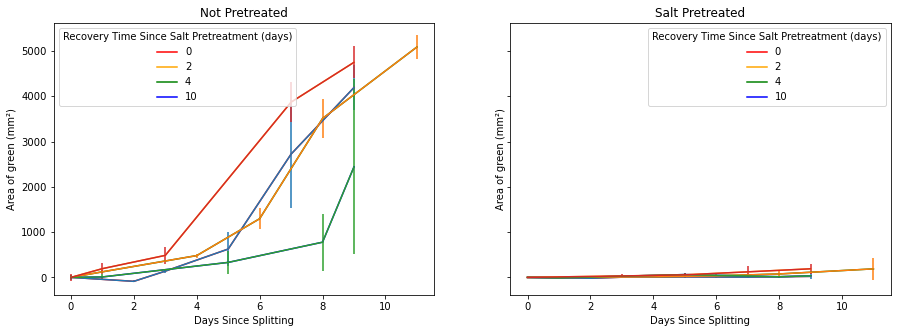

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (15, 5))
for cond in cond_dict:
    #organizing by time in case the images were uploaded in the wrong order
    d = dict(sorted(cond_dict[cond].items()))
    
    x = list(d.keys())
    y = list(d.values())
    
    err = dict(sorted(err_dict[cond].items()))
    e = list(err.values())
    
    #set the color for the line based on the number of days since changing media
    days = cond[1]
    color = 'red'
    days = int(days)
    if days == 2:
        color = 'orange'
    elif days == 4:
        color = 'green'
    elif days == 10:
        color = 'blue'
    
    if 'No' in cond[0]: #if not salt pretreated, plot in the first plot
        ax1.plot([i - x[0] for i in x] , [i - y[0] for i in y], color = color, label = cond[1])
        ax1.set_title("Not Pretreated")
        ax1.set_ylabel("Area of green ({}\u00b2)".format("mm"))
        ax1.set_xlabel("Days Since Splitting")
        ax1.errorbar([i - x[0] for i in x] , [i - y[0] for i in y], e)
    else:
        ax2.plot([i - x[0] for i in x] , [i - y[0] for i in y], color = color, label = cond[1])
        ax2.set_title("Salt Pretreated")
        ax2.set_ylabel(("Area of green ({}\u00b2)".format("mm")))
        ax2.set_xlabel("Days Since Splitting")
        ax2.errorbar([i - x[0] for i in x] , [i - y[0] for i in y], e)
        
handles, labels = ax1.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
ax1.legend(handles, labels, title = "Recovery Time Since Salt Pretreatment (days)")
handles, labels = ax2.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0])))
ax2.legend(handles, labels, title = "Recovery Time Since Salt Pretreatment (days)")
